<a href="https://colab.research.google.com/github/endrieb99/sentiementanalysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install better_profanity
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 KB 2.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 4.5 MB/s eta 0:00:00


In [ ]:
# Import the necessary libraries
import re
import tweepy
import nltk
from tweepy import OAuthHandler
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import json
from textblob import TextBlob
from nltk.stem.porter import *
from collections import Counter

import plotly.express as pxnp
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.utils import resample
from better_profanity import profanity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Initialize Twitter api 
def init_twitter_api():
  # API Key
  consumer_key = 'v87i14mp7M9JdCSkd5TVrS8Bo'
  consumer_secret = 'X8dQjpZ5I0x0xGjChMFdIbJ1cgzGe01NfQNxAwZAeqydsT4qoG'
  access_token = '1404028707346563073-3jTvQOpROLk5vd5SMuavvam4ibqzz9'
  access_token_secret = 'w6dV8bKp08S7vUydjDjzHx3zslMPnpvFi7LlkEVw4MLmJ'

  # Access Twitter Data
  auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  auth.set_access_token(access_token, access_token_secret)

  api = tweepy.API(auth)
  return api

In [ ]:
# Fetch tweets with query from user
def get_tweets_from_api(api_query_count, query):
  #Filter the query to remove retweets
  filtered = query + "-filter:retweets"

  #Generate the latest tweets on the given query
  api = init_twitter_api()
  tweets = tweepy.Cursor(
      api.search, 
      q=filtered, 
      lang="en").items(api_query_count)

  tweet_list = []
  for tweet in tweets:
    tweet_list.append([tweet.id, tweet.source_url, tweet.text, tweet.created_at, 
                      tweet.retweet_count, tweet.favorite_count, tweet.user.location])
    
  return tweet_list

In [ ]:
def list_to_data_frame(tweet_list):
  # Convert the list into a dataframe
  df = pd.DataFrame(data=tweet_list, columns = ['ID', 'Link', 'Tweets', 
                                              'Date', 'Retweets', 
                                              'Favorites', 'Location'])
  return df

In [ ]:
# Create a function to clean the tweets
# Data Preprocessing
def clean_tweets(txt):
# changing tweet text to lowercase
  txt = str(txt).lower()
# remove profanity
  txt = profanity.censor(txt)
  txt = re.sub("@[A-Za-z0-9_]+","", txt)
  txt = re.sub("#[A-Za-z0-9_]+","", txt)
  txt = re.sub(r'http\S+', '', txt)
  txt = re.sub('[()!?]', ' ', txt)
  txt = re.sub('\[.*?\]',' ', txt)
  txt = re.sub("[^a-z0-9]"," ", txt)
  txt = txt.split()
  txt = " ".join(word for word in txt)
  
  return txt

In [ ]:
# Handle stopwords
def remove_stop_word(txt):
    stop_words = stopwords.words('english')
    stopwords_dict = Counter(stop_words)
    text = " ".join([word for word in txt.split() if word not in stopwords_dict])
    return text

In [ ]:
def add_tweet_polarity_score_compound(tweet):
  analyser = SentimentIntensityAnalyzer()

  score = analyser.polarity_scores(tweet)
  compound = score['compound']
  negative = score['neg']
  neutral = score['neu']
  positive = score['pos']
 
  return compound

In [ ]:
def polarity_to_score(compound):
  score = (compound + 1) * 5
  return score

In [ ]:
#Defining a function to assign sentiments (positive, negative or neutral)
def classify_tweets_polarity(compound):
  # The Compound score is a metric that has been scaled between -1 as the most extreme negative score and +1 as the most extreme positive score
  # positive sentiment = compound score >= 0.05
  # neutral sentiment = (compound score > -0.05) and (compound score < 0.05)
  # negative sentiment = compound score <= -0.05

  if (compound <= -0.05):
    return "Negative"
  elif (-0.05 > compound < 0.05):
    return "Neutral"
  else:
    return "Positive"

In [ ]:
def create_count_plot(data_frame):
  fig = plt.figure(figsize=(5,5))
  sns.countplot(x='Polarity', data = data_frame)

In [ ]:
def create_sentiments_distribution_pie_chart(data_frame):
  # Creating Pie Chart for Sentiment Column
  import plotly.express as px
  fig = px.pie(data_frame, names='Polarity', title ='Distribution of sentiments')
  fig.show()

In [ ]:
def extract_tweet_sentiments(data_frame, column):
  # Exctracting tweets
  tweets = data_frame[data_frame.Polarity == column]
  tweets = tweets.sort_values(["Polarity"], ascending = True)
  return tweets

In [ ]:
def create_word_cloud_from_tweets(tweets):
  text = ' '.join([word for word in tweets['Tweets']])
  if text:
    word_cloud = WordCloud(max_words=50, width=1600, height=800).generate(text)
    return word_cloud
  else:
    return None

In [ ]:
def show_word_cloud(word_cloud, column):
  plt.figure(figsize=(20,15), facecolor='None')
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.title('Most frequent words in ' + column +' tweets', fontsize=19)
  plt.show()

In [ ]:
def get_compound_average(data_frame):
  compound_average = sum(data_frame['Compound']) / len(data_frame['Compound'])
  formatted_compound_average = '{0:.2f}'.format(compound_average)
  return formatted_compound_average

In [ ]:
def get_ip_score(data_frame):
  score = sum(data_frame['Score']) / len(data_frame['Score'])
  formatted_score = '{0:.2f}'.format(score)
  return formatted_score

In [ ]:
def get_purchase_advice(compound):
  compound_to_float = float(compound)
  print("Compount to Float", compound_to_float) 
  if compound_to_float >= 0.5:
    return "Based on comments and sentiments analysed from Social Media, it appears that the overall opinion of this product is highly positive. \n\nThis means that most of reviews express a positive emotion towards the product. This suggest that the product is likely to have a good overall quality and satisfy ones need. \n\nYou should consider purchasing it."
  elif compound_to_float > -0.5 and compound_to_float < 0.5:
    return "Based on comments and sentiments analysed from Social Media, it appears that the overall opinion of this product is neutral. \n\nThis means that the amount of positive and negative comments about the product are balanced. You should carefully consider the product before making a purchase. \n\nLook for additional information about the product, read reviews from different sources, compare it with other similar products to weigh the pros and cons."
  else:
    return "Based on comments and sentiments analysed from Social Media, it appears that the overall opinion of this product is highly negative. \n\nThis means that most of the comments and reviews express a negative emotion towards the product. This suggest that the product may have some issues based on your keyphrase or it may not satisfy ones overall needs. \n\nYou should avoid purchasing it, or do a more thorough research before making a decision."

In [ ]:
def get_frequent_words_list(column):
  # Convert the column to a list
  text_list = column.tolist()

  # Join all the words in the list into a single string
  text_string = " ".join(text_list)

  # Tokenize the string into a list of words
  text_list = word_tokenize(text_string)

  # Use the Counter class to get the frequency of each word
  word_count = Counter(text_list)

  # Get the most frequent words
  most_common_words = word_count.most_common(25)

  # Get the most frequent words list without frequency
  most_common_words_list = [word for word, frequency in most_common_words]

  return most_common_words_list

In [ ]:
def get_frequent_words(positive_words, negative_words, neutral_words):
  return {'positive': positive_words, 'negative': negative_words, 'neutral': neutral_words}

In [ ]:
def get_tweets(positive_tweets, negative_tweets, neutral_tweets):
  return {'positive': positive_tweets[0:20].to_dict('records'), 'negative': negative_tweets[0:20].to_dict('records'), 'neutral': neutral_tweets[0:20].to_dict('records')}

In [ ]:
def generate_report_json(api_query_count, ip_score, purchase_advice, frequent_words, tweets):
  return {'Report': {'APIQueryCount': api_query_count, 'IPScore': ip_score, 'PurchaseAdvice': purchase_advice, 'FrequentWords': frequent_words, 'Tweets': tweets}}

In [ ]:
def convert_dictionary_to_json(report):
  json_object = json.dumps(report, indent=4, sort_keys=True, default=str)

  return json_object

In [ ]:
# Save report to json file
def save_json_to_file(json_object):
  # Save report to json file
  with open('sentiment_analysis_report.json', 'w') as f:
    f.write(json_object)

In [ ]:
def get_sentiment_analysis_report(api_query_count, query):
  
  # Step 1 --- Fetch Tweet List
  # Define how many tweets to get from the Twitter API
  tweet_list = get_tweets_from_api(api_query_count, query)
  tweet_list_count = len(tweet_list)
  print("Tweets list length: ", tweet_list_count)

  if not tweet_list_count:
    final_report = convert_dictionary_to_json({'Report': None})
    print("Sentiment Analysis Final Report: ", final_report)
    save_json_to_file(final_report)
    return final_report


  # Step 2 --- Convert list to Data Frame
  data_frame = list_to_data_frame(tweet_list)
  data_frame.head(20)
  print(data_frame.shape)


  # Step 3 --- Clean tweets
  data_frame['Tweets'] = data_frame['Tweets'].apply(lambda tw: clean_tweets(tw))


  # Step 4 --- Remove Stop Words
  data_frame['Tweets'] = data_frame['Tweets'].apply(lambda tw: remove_stop_word(tw))
  data_frame.head(10)
  print(data_frame.shape)


  # Step 5 --- Determine polarity scores
  data_frame['Compound'] = data_frame['Tweets'].apply(add_tweet_polarity_score_compound)
  data_frame.head(20)


  # Step 6 --- Convert compound score of scale -1...1 to scale 1...10
  data_frame['Score'] = data_frame['Compound'].apply(polarity_to_score)


  # Step 7 --- Classify tweets: assign sentiments 
  data_frame['Polarity'] = data_frame['Compound'].apply(classify_tweets_polarity)
  data_frame.head(20)
  print(data_frame.shape)
  data_frame.duplicated().sum()
  data_frame.isnull().sum().sum()
  data_frame['Polarity'].value_counts()


  # Step 8 --- Create count plot
  create_count_plot(data_frame)


  # Step 9 --- Create Sentiments Distribution Pie Chart
  create_sentiments_distribution_pie_chart(data_frame)


  # Step 10 --- Extract sentiments from tweets
  positive_tweets = extract_tweet_sentiments(data_frame, "Positive")
  negative_tweets = extract_tweet_sentiments(data_frame, "Negative")
  neutral_tweets = extract_tweet_sentiments(data_frame, "Neutral")


  # # Step 11 --- Create word cloud from tweets
  positive_word_cloud = create_word_cloud_from_tweets(positive_tweets)
  negative_word_cloud = create_word_cloud_from_tweets(negative_tweets)
  neutral_word_cloud = create_word_cloud_from_tweets(neutral_tweets)


  # Step 12 --- Show word_cloud image
  if positive_word_cloud is not None: show_word_cloud(positive_word_cloud, "Positive")
  if negative_word_cloud is not None: show_word_cloud(negative_word_cloud, "Negative")
  if neutral_word_cloud is not None: show_word_cloud(neutral_word_cloud, "Neutral")


  # Step 13 --- Get frequent words from word_cloud
  positive_words = get_frequent_words_list(positive_tweets['Tweets'])
  negative_words = get_frequent_words_list(negative_tweets['Tweets'])
  neutral_words = get_frequent_words_list(neutral_tweets['Tweets'])

  # Step 14 --- Generate report dictionary
  ip_score = get_ip_score(data_frame)
  compound_average = get_compound_average(data_frame)
  purchase_advice = get_purchase_advice(compound_average)
  frequent_words = get_frequent_words(positive_words, negative_words, neutral_words)
  tweets = get_tweets(positive_tweets, negative_tweets, neutral_tweets)

  report = generate_report_json(api_query_count, ip_score, purchase_advice, frequent_words, tweets)
  print(type(report))


  # Step 15 --- Convert dictionary to json
  final_report = convert_dictionary_to_json(report)
  print("Sentiment Analysis Final Report: ", final_report)

  
  # Step 16 --- Save json to file
  save_json_to_file(final_report)

  return final_report

Tweets list length:  69
(69, 7)
(69, 7)
(69, 10)


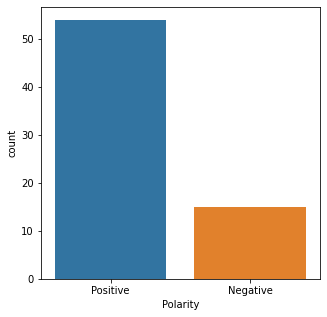

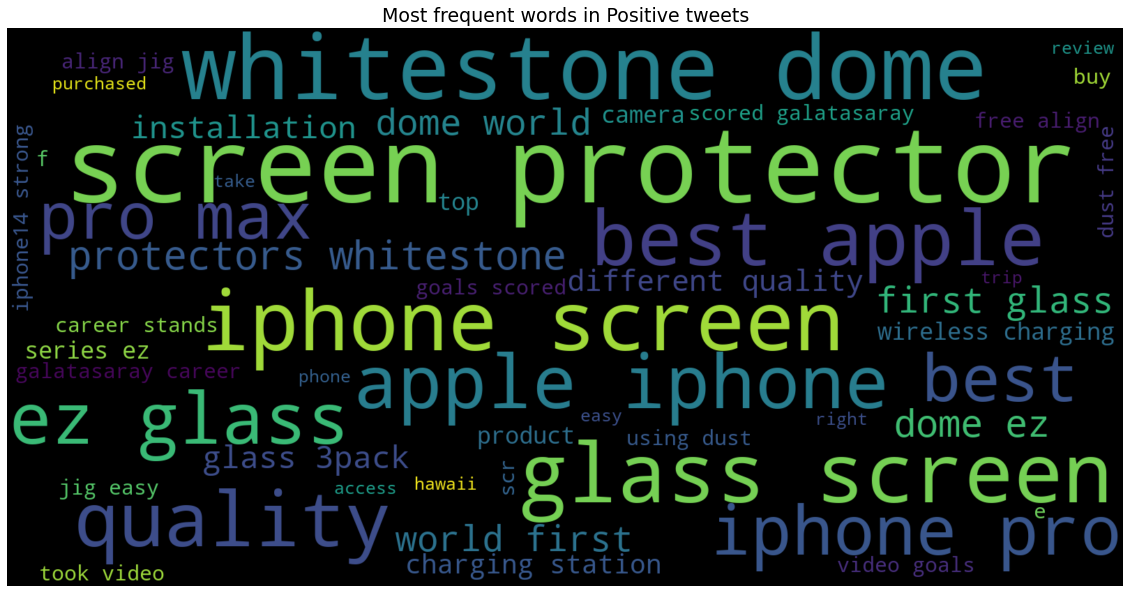

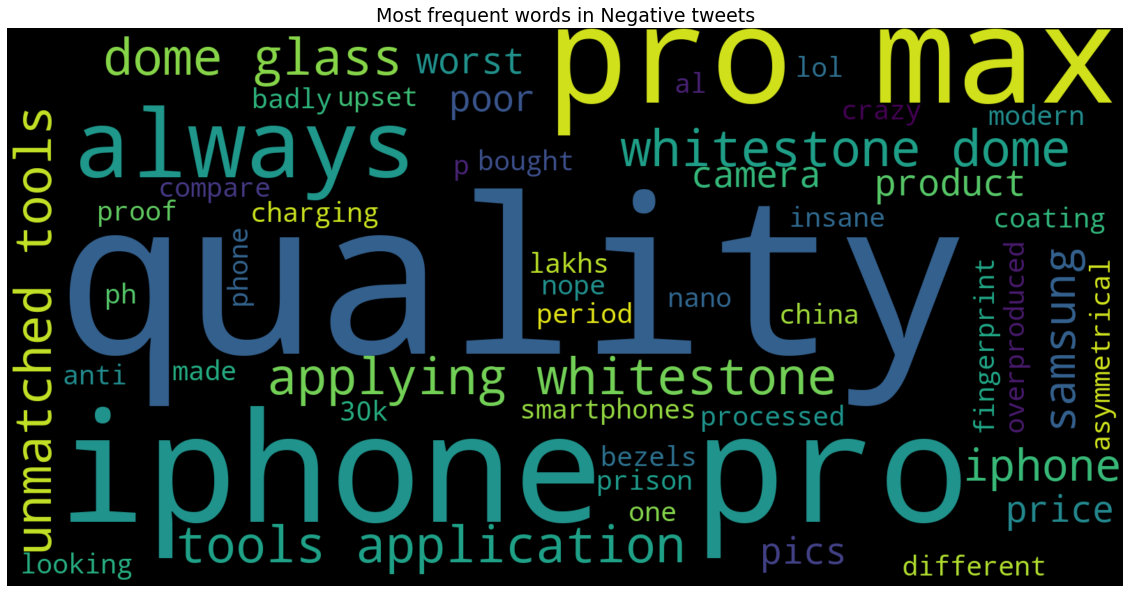

Compount to Float 0.33
<class 'dict'>
Sentiment Analysis Final Report:  {
    "Report": {
        "APIQueryCount": 5000,
        "FrequentWords": {
            "negative": [
                "iphone",
                "14",
                "quality",
                "pro",
                "max",
                "applying",
                "whitestone",
                "dome",
                "glass",
                "always",
                "unmatched",
                "tools",
                "application",
                "samsung",
                "worst",
                "pics",
                "poor",
                "price",
                "compare",
                "anti",
                "fingerprint",
                "coating",
                "made",
                "china",
                "products"
            ],
            "neutral": [],
            "positive": [
                "14",
                "iphone",
                "screen",
                "glass",
          

'{\n    "Report": {\n        "APIQueryCount": 5000,\n        "FrequentWords": {\n            "negative": [\n                "iphone",\n                "14",\n                "quality",\n                "pro",\n                "max",\n                "applying",\n                "whitestone",\n                "dome",\n                "glass",\n                "always",\n                "unmatched",\n                "tools",\n                "application",\n                "samsung",\n                "worst",\n                "pics",\n                "poor",\n                "price",\n                "compare",\n                "anti",\n                "fingerprint",\n                "coating",\n                "made",\n                "china",\n                "products"\n            ],\n            "neutral": [],\n            "positive": [\n                "14",\n                "iphone",\n                "screen",\n                "glass",\n                "dome",\n                "be

In [ ]:
# get_sentiment_analysis_report("iPhone 14 Pro Max camera")
get_sentiment_analysis_report(5000, "iPhone 14 Pro Max quality")